# Neural & Behavioral Modeling - Week 12 (Exercises)
by 李采蓉 b08207042@ntu.edu.tw

In [1]:
%config IPCompleter.greedy=True 
%matplotlib inline
from matplotlib.pyplot import *
from IPython.display import *
import numpy as np
import torch as t
from torch import nn
from torch import optim

In [2]:
# Check GPU status:
print('PyTorch version:',t.__version__)
use_cuda=t.cuda.is_available()
if(use_cuda):
    for i in range(t.cuda.device_count()):
        print('Device ',i,':',t.cuda.get_device_name(i))
    print('Current: Device ',t.cuda.current_device())
    t.backends.cudnn.benchmark = True 
    device = t.device("cuda")
else:
    device = t.device("cpu")
    print('No GPU')

PyTorch version: 1.12.1+cu113
No GPU


In [9]:
# Supporting functions:

from datetime import datetime

def get_acc(output, label):
    total = output.shape[0]
    _, pred_label = output.max(1)
    num_correct = (pred_label == label).sum().item()
    return num_correct / total


def train(acc, val, device, net, train_data, valid_data, num_epochs, optimizer, criterion):
    if t.cuda.is_available():
        net = net.cuda()
    prev_time = datetime.now()
    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        net = net.train()
        #for im, label in train_data:
        for im, label in train_data:
            im=im.view(-1,im.shape[2],im.shape[3])
            im = im.to(device)  # (bs, h, w)
            label = label.to(device)
            # forward
            output = net(im)
            loss = criterion(output, label)
            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.data.item()
            train_acc += get_acc(output, label)

        cur_time = datetime.now()
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        if valid_data is not None:
            valid_loss = 0
            valid_acc = 0
            net = net.eval()
            for im, label in valid_data:
                with t.no_grad():
                    im=im.view(-1,im.shape[2],im.shape[3])
                    im = im.to(device)
                    label = label.to(device)
                    # print(label, '\n')
                output = net(im)
                loss = criterion(output, label)
                valid_loss += loss.data.item()
                valid_acc += get_acc(output, label)
            acc.append(valid_acc/len(valid_data))
            val.append(valid_loss/len(valid_data))
            epoch_str = (
                "Epoch %d. Train Loss: %f, Train Acc: %f, Valid Loss: %f, Valid Acc: %f, "
                % (epoch, train_loss / len(train_data),
                   train_acc / len(train_data), valid_loss / len(valid_data),
                   valid_acc / len(valid_data)))
        else:
            epoch_str = ("Epoch %d. Train Loss: %f, Train Acc: %f, " %
                         (epoch, train_loss / len(train_data),
                          train_acc / len(train_data)))
        prev_time = cur_time
        print(epoch_str + time_str)

In [10]:
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],std=[0.5])])

train_set = datasets.MNIST(root = "./data",
                               transform = transform,
                               train = True,
                               download = True)

train_data = t.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)


test_set = datasets.MNIST(root = "./data",
                              transform = transform,
                              train = False)

test_data = t.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## 1. RNN on images (4 points)
Note that the RNN-based MNIST classifier in 2.1.1 of model_12_examples.ipynb did not apply a softmax as the response function of its last layer.

Does adding a softmax make any difference in model prediciton performance? Why or why not?

Refs:

[1] https://pytorch.org/docs/stable/nn.html 

[2] https://pytorch.org/docs/stable/nn.functional.html 

[3] https://pytorch.org/docs/stable/_modules/torch/nn/modules/loss.html

In [ ]:
# Thoe model in 2.1.1 of 13_examples.ipynb:

class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size = 28,
                                hidden_size = 128,
                                num_layers = 1,
                                batch_first = True)
        
        self.classifier = nn.Linear(128,10)
        
    def forward(self, input):
        output,_ = self.rnn(input, None)
        output = self.classifier(output[:,-1,:])
        return output

In [ ]:
# Please run your computational experiments and write your observations accordingly.
srn = RNN()
optimizer = optim.Adam(srn.parameters())
criterion = nn.CrossEntropyLoss()
acc_ori=[]
val_ori=[]
train(acc_ori, val_ori, device, srn, train_data, test_data, 10, optimizer, criterion)

Epoch 0. Train Loss: 0.751204, Train Acc: 0.751449, Valid Loss: 0.416939, Valid Acc: 0.879180, Time 00:00:22
Epoch 1. Train Loss: 0.318930, Train Acc: 0.909815, Valid Loss: 0.236395, Valid Acc: 0.931628, Time 00:00:24
Epoch 2. Train Loss: 0.235555, Train Acc: 0.933136, Valid Loss: 0.223305, Valid Acc: 0.937002, Time 00:00:25
Epoch 3. Train Loss: 0.193346, Train Acc: 0.945312, Valid Loss: 0.184548, Valid Acc: 0.949642, Time 00:00:25
Epoch 4. Train Loss: 0.169598, Train Acc: 0.953075, Valid Loss: 0.183374, Valid Acc: 0.950936, Time 00:00:25
Epoch 5. Train Loss: 0.155688, Train Acc: 0.956507, Valid Loss: 0.162294, Valid Acc: 0.955115, Time 00:00:26
Epoch 6. Train Loss: 0.146155, Train Acc: 0.958755, Valid Loss: 0.150901, Valid Acc: 0.958997, Time 00:00:25
Epoch 7. Train Loss: 0.139088, Train Acc: 0.961387, Valid Loss: 0.144385, Valid Acc: 0.959992, Time 00:00:25
Epoch 8. Train Loss: 0.129831, Train Acc: 0.964119, Valid Loss: 0.133457, Valid Acc: 0.962480, Time 00:00:25
Epoch 9. Train Loss

In [ ]:
class RNN_fixed(nn.Module):
    def __init__(self):
        super(RNN_fixed, self).__init__()
        self.rnn = nn.RNN(input_size = 28,
                                hidden_size = 128,
                                num_layers = 1,
                                batch_first = True)
        
        self.classifier = nn.Linear(128,10)
        
    def forward(self, input):
        output,_ = self.rnn(input, None)
        output = self.classifier(output[:,-1,:])
        return nn.softmax(output, dim=1)

In [ ]:
srn_f = RNN_fixed()
optimizer = optim.Adam(srn_f.parameters())
criterion = nn.CrossEntropyLoss()
acc_fixed=[]
val_fixed=[]
train(acc_fixed, val_fixed, device, srn, train_data, test_data, 10, optimizer, criterion)

Epoch 0. Train Loss: 0.095886, Train Acc: 0.972698, Valid Loss: 0.121367, Valid Acc: 0.965068, Time 00:00:21
Epoch 1. Train Loss: 0.095856, Train Acc: 0.972715, Valid Loss: 0.121836, Valid Acc: 0.964769, Time 00:00:23
Epoch 2. Train Loss: 0.095922, Train Acc: 0.972698, Valid Loss: 0.121603, Valid Acc: 0.964769, Time 00:00:23
Epoch 3. Train Loss: 0.095907, Train Acc: 0.972698, Valid Loss: 0.123403, Valid Acc: 0.964769, Time 00:00:23
Epoch 4. Train Loss: 0.095933, Train Acc: 0.972681, Valid Loss: 0.121160, Valid Acc: 0.965068, Time 00:00:24
Epoch 5. Train Loss: 0.095904, Train Acc: 0.972698, Valid Loss: 0.121284, Valid Acc: 0.965068, Time 00:00:23
Epoch 6. Train Loss: 0.095859, Train Acc: 0.972715, Valid Loss: 0.121422, Valid Acc: 0.965068, Time 00:00:24
Epoch 7. Train Loss: 0.095861, Train Acc: 0.972715, Valid Loss: 0.122677, Valid Acc: 0.964471, Time 00:00:24
Epoch 8. Train Loss: 0.095860, Train Acc: 0.972715, Valid Loss: 0.121555, Valid Acc: 0.964769, Time 00:00:24
Epoch 9. Train Loss

Text(0.5, 1.0, 'accuracy')

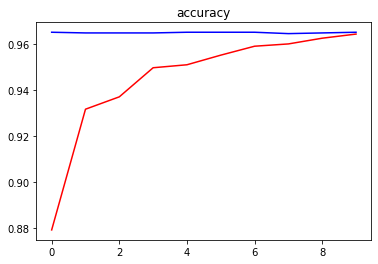

In [ ]:
plot(acc_ori, 'r', label='no softmax')
plot(acc_fixed, 'b', label='with sofmax')
legend
title("accuracy")

Text(0.5, 1.0, 'loss')

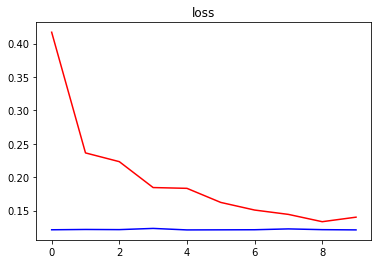

In [ ]:
plot(val_ori, 'r', label='no softmax')
plot(val_fixed, 'b', label='with sofmax')
legend
title("loss")

**討論**：<br>
softmax的作用基本上就是將所有可能值映射到[0,1]區間內，最後選擇機率最大的輸出，可以視作bernoulli distribution的應用。從試驗結果上來看，加了softmax的表現會比較好，從最開始就可以達到0.96以上的準確率。<br>
延伸閱讀：[初学日2-激活函数-softmax函数-rnn循环神经网络](https://blog.csdn.net/qq_24059779/article/details/83545096#t17)

## 2. RNN v.s. CNN (4 points)
Compare the results of 2.2.1 (RNN) & 2.3.1 (CNN) in model_12_examples.ipynb.

The 1D-CNN seems to predict the time series better than the RNN. Why?

You may verify your hypotheses by computational experiments.

### Data

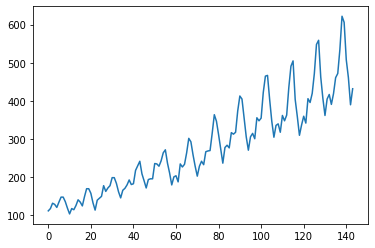

In [3]:
import pandas as pd
ts = pd.read_csv('data.csv', usecols=[1]).dropna().values.astype('float32')
plot(ts); 

144


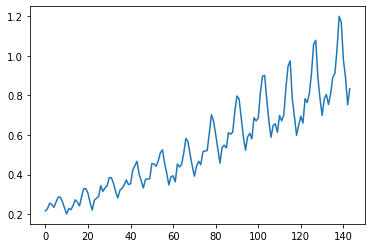

In [4]:
# Normalize:
max_value = np.max(ts)
min_value = np.min(ts)
scalar = max_value - min_value
ts = list(map(lambda x: x / scalar, ts))
print(len(ts))
plot(ts); 

#### 2.2.1 RNN

In [13]:
# Prepare windowed data for our RNN model(s):
def create_dataset(dataset, look_back=2):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

data_X, data_Y = create_dataset(ts)

print(data_X[0],data_Y[0]) # (Xt-2, Xt-1) -> Xt

[[0.21621622]
 [0.22779922]] [0.25482625]


In [14]:
# Train-Test split:
train_size = int(len(data_X) * 0.7) # 70% for training
test_size = len(data_X) - train_size
train_X = data_X[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X[train_size:]
test_Y = data_Y[train_size:]

print(train_X.shape,train_Y.shape)

(99, 2, 1) (99, 1)


In [15]:
# Reshape the data into (seq, batch, featue)
train_X = train_X.reshape(-1, 1, 2)
train_Y = train_Y.reshape(-1, 1, 1)
test_X = test_X.reshape(-1, 1, 2)

train_x = t.from_numpy(train_X)
train_y = t.from_numpy(train_Y)
test_x = t.from_numpy(test_X)

print(train_x.shape,train_y.shape)

torch.Size([99, 1, 2]) torch.Size([99, 1, 1])


In [16]:
class lstm_reg(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super(lstm_reg, self).__init__()
        
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers) # rnn
        self.reg = nn.Linear(hidden_size, output_size) # regression
        
    def forward(self, x):
        x, _ = self.rnn(x) # (seq, batch, hidden)
        s, b, h = x.shape
        x = x.view(s*b, h) # flatten
        x = self.reg(x)
        x = x.view(s, b, -1)
        return x

In [17]:
net = lstm_reg(input_size=2, hidden_size=10)
criterion = nn.MSELoss()
optimizer = t.optim.Adam(net.parameters(),lr=1e-2)

In [20]:
# Training:
for e in range(1000):
    # Forward:
    out = net(train_x)
    loss = criterion(out, train_y)
    # Backward:
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 100 == 0: # print loss every 100 epochs
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))

Epoch: 100, Loss: 0.00362
Epoch: 200, Loss: 0.00305
Epoch: 300, Loss: 0.00173
Epoch: 400, Loss: 0.00092
Epoch: 500, Loss: 0.00062
Epoch: 600, Loss: 0.00064
Epoch: 700, Loss: 0.00061
Epoch: 800, Loss: 0.00071
Epoch: 900, Loss: 0.00092
Epoch: 1000, Loss: 0.00042


torch.Size([142, 1, 1]) (142,) 144


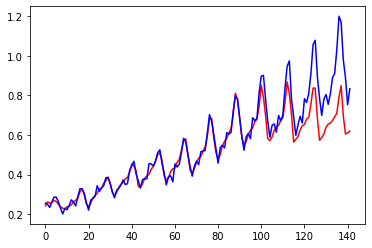

In [23]:
# Testing on the whole series (70% trained + 30% untrained):
net = net.eval() 
data_X2 = data_X.reshape(-1, 1, 2)
data_X3 = t.from_numpy(data_X2)
pred_test1 = net(data_X3) 
pred_test2 = pred_test1.view(-1).data.numpy() # reshaping to a simple time series
print(pred_test1.shape, pred_test2.shape, len(ts))

# Visualization:
plot(pred_test2, 'r', label='prediction')
plot(ts[2:], 'b', label='real');

#### 2.3.1 CNN

In [30]:
# Train-Test split:
data_X4 = np.swapaxes(data_X,1,2) # should be (batch, channel, input)
L=data_X4.shape[0]
train_size = int(L * 0.7) # 70% for training
test_size = L - train_size
train_X = data_X4[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X4[train_size:]
test_Y = data_Y[train_size:]

train_x = t.from_numpy(train_X)
train_y = t.from_numpy(train_Y)
test_x = t.from_numpy(test_X)

print(train_x.shape,train_y.shape) # (batch,input,feature)

torch.Size([99, 1, 2]) torch.Size([99, 1])


In [33]:
class cnn_reg(nn.Module):
    def __init__(self, in_channels, hidden_size, output_size, kernel_size):
        super(cnn_reg, self).__init__()
        
        self.conv = nn.Conv1d(in_channels=in_channels, out_channels=hidden_size, kernel_size=kernel_size) # in_channels=features

        self.reg = nn.Linear(hidden_size, output_size) # regression
        
    def forward(self, x):
        x = self.conv(x) # (batch, channel, input)
        x=x.view(x.size()[0], -1) # flatten
        x = self.reg(x)
        return x

In [34]:
net = cnn_reg(in_channels=1, hidden_size=10, output_size=1, kernel_size=2)
criterion = nn.MSELoss()
optimizer = t.optim.Adam(net.parameters(),lr=1e-2)

In [35]:
# Training:
for e in range(1000):
    # Forward:
    out = net(train_x)
    loss = criterion(out, train_y)
    # Backward:
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 100 == 0: # print loss every 100 epochs
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))

Epoch: 100, Loss: 0.00411
Epoch: 200, Loss: 0.00366
Epoch: 300, Loss: 0.00322
Epoch: 400, Loss: 0.00282
Epoch: 500, Loss: 0.00249
Epoch: 600, Loss: 0.00224
Epoch: 700, Loss: 0.00207
Epoch: 800, Loss: 0.00197
Epoch: 900, Loss: 0.00192
Epoch: 1000, Loss: 0.00191


torch.Size([142, 1]) (142,) 144


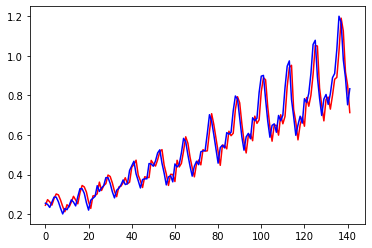

In [36]:
# Testing on the whole series (70% trained + 30% untrained):
net = net.eval() 
pred_test1 = net(t.from_numpy(data_X4))
pred_test2 = pred_test1.view(-1).data.numpy() # reshaping to a simple time series
print(pred_test1.shape, pred_test2.shape, len(ts))

# Visualization:
plot(pred_test2, 'r', label='prediction')
plot(ts[2:], 'b', label='real');

**討論**：<br>
上面兩個模型中，數據中相鄰的值在CNN模型的影響會大於LSTM模型中的影響，這也就是為什麼像時間序列這類型很看重前面數據，使用1D-CNN的效果會比LSTM好得多。如果要改進這個LSTM模型的話，也許可以將time window的寬度拉長，讓模型訓練起來更全面一點。

延伸閱讀：[时间序列数据分析101 - (14) LSTM模型的应用（Pytorch搭建和Darts调用两种方法）](https://zhuanlan.zhihu.com/p/392828302)<br>
&emsp;&emsp;&emsp;&emsp;&emsp;[时间序列数据分析101 - (15) 1D CNN 一维卷积神经网络](https://zhuanlan.zhihu.com/p/393565498)<br>
&emsp;&emsp;&emsp;&emsp;&emsp;[时间序列数据分析101 - (16) 模型评估的考虑](https://zhuanlan.zhihu.com/p/394810448)

#### 當window size=5

In [ ]:
window_size=5

In [60]:
# Prepare windowed data for our RNN model(s):
def create_dataset(dataset, look_back=window_size):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

data_X, data_Y = create_dataset(ts)

print(data_X[0],data_Y[0]) # (Xt-2, Xt-1) -> Xt

[[0.21621622]
 [0.22779922]
 [0.25482625]
 [0.24903475]
 [0.23359074]] [0.26061776]


In [61]:
# Train-Test split:
train_size = int(len(data_X) * 0.7) # 70% for training
test_size = len(data_X) - train_size
train_X = data_X[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X[train_size:]
test_Y = data_Y[train_size:]

print(train_X.shape,train_Y.shape)

(97, 5, 1) (97, 1)


In [62]:
# Reshape the data into (seq, batch, featue)
train_X = train_X.reshape(-1, 1, window_size)
train_Y = train_Y.reshape(-1, 1, 1)
test_X = test_X.reshape(-1, 1, window_size)

train_x = t.from_numpy(train_X)
train_y = t.from_numpy(train_Y)
test_x = t.from_numpy(test_X)

print(train_x.shape,train_y.shape)

torch.Size([97, 1, 5]) torch.Size([97, 1, 1])


In [63]:
class lstm_reg(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super(lstm_reg, self).__init__()
        
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers) # rnn
        self.reg = nn.Linear(hidden_size, output_size) # regression
        
    def forward(self, x):
        x, _ = self.rnn(x) # (seq, batch, hidden)
        s, b, h = x.shape
        x = x.view(s*b, h) # flatten
        x = self.reg(x)
        x = x.view(s, b, -1)
        return x

In [64]:
net = lstm_reg(input_size=window_size, hidden_size=10)
criterion = nn.MSELoss()
optimizer = t.optim.Adam(net.parameters(),lr=1e-2)

In [65]:
# Training:
for e in range(1000):
    # Forward:
    out = net(train_x)
    loss = criterion(out, train_y)
    # Backward:
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 100 == 0: # print loss every 100 epochs
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))

Epoch: 100, Loss: 0.00450
Epoch: 200, Loss: 0.00424
Epoch: 300, Loss: 0.00358
Epoch: 400, Loss: 0.00153
Epoch: 500, Loss: 0.00099
Epoch: 600, Loss: 0.00049
Epoch: 700, Loss: 0.00047
Epoch: 800, Loss: 0.00042
Epoch: 900, Loss: 0.00040
Epoch: 1000, Loss: 0.00037


torch.Size([139, 1, 1]) (139,) 144


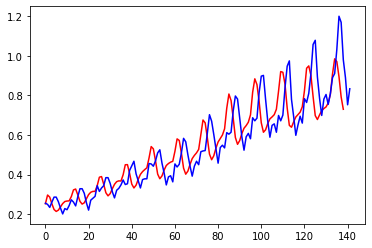

In [67]:
# Testing on the whole series (70% trained + 30% untrained):
net = net.eval() 
data_X2 = data_X.reshape(-1, 1, window_size)
data_X3 = t.from_numpy(data_X2)
pred_test1 = net(data_X3) 
pred_test2 = pred_test1.view(-1).data.numpy() # reshaping to a simple time series
print(pred_test1.shape, pred_test2.shape, len(ts))

# Visualization:
plot(pred_test2, 'r', label='prediction')
plot(ts[2:], 'b', label='real');

#### 當window size=10

In [112]:
window_size=10

In [113]:
# Prepare windowed data for our RNN model(s):
def create_dataset(dataset, look_back=window_size):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

data_X, data_Y = create_dataset(ts)

print(data_X[0],data_Y[0]) # (Xt-2, Xt-1) -> Xt

[[0.21621622]
 [0.22779922]
 [0.25482625]
 [0.24903475]
 [0.23359074]
 [0.26061776]
 [0.2857143 ]
 [0.2857143 ]
 [0.26254827]
 [0.22972973]] [0.2007722]


In [114]:
# Train-Test split:
train_size = int(len(data_X) * 0.7) # 70% for training
test_size = len(data_X) - train_size
train_X = data_X[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X[train_size:]
test_Y = data_Y[train_size:]

print(train_X.shape,train_Y.shape)

(93, 10, 1) (93, 1)


In [115]:
# Reshape the data into (seq, batch, featue)
train_X = train_X.reshape(-1, 1, window_size)
train_Y = train_Y.reshape(-1, 1, 1)
test_X = test_X.reshape(-1, 1, window_size)

train_x = t.from_numpy(train_X)
train_y = t.from_numpy(train_Y)
test_x = t.from_numpy(test_X)

print(train_x.shape,train_y.shape)

torch.Size([93, 1, 10]) torch.Size([93, 1, 1])


In [116]:
class lstm_reg(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super(lstm_reg, self).__init__()
        
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers) # rnn
        self.reg = nn.Linear(hidden_size, output_size) # regression
        
    def forward(self, x):
        x, _ = self.rnn(x) # (seq, batch, hidden)
        s, b, h = x.shape
        x = x.view(s*b, h) # flatten
        x = self.reg(x)
        x = x.view(s, b, -1)
        return x

In [117]:
net = lstm_reg(input_size=window_size, hidden_size=10)
criterion = nn.MSELoss()
optimizer = t.optim.Adam(net.parameters(),lr=1e-2)

In [118]:
# Training:
for e in range(1000):
    # Forward:
    out = net(train_x)
    loss = criterion(out, train_y)
    # Backward:
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 100 == 0: # print loss every 100 epochs
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))

Epoch: 100, Loss: 0.00439
Epoch: 200, Loss: 0.00245
Epoch: 300, Loss: 0.00116
Epoch: 400, Loss: 0.00067
Epoch: 500, Loss: 0.00068
Epoch: 600, Loss: 0.00058
Epoch: 700, Loss: 0.00057
Epoch: 800, Loss: 0.00047
Epoch: 900, Loss: 0.00052
Epoch: 1000, Loss: 0.00038


torch.Size([134, 1, 1]) (134,) 144


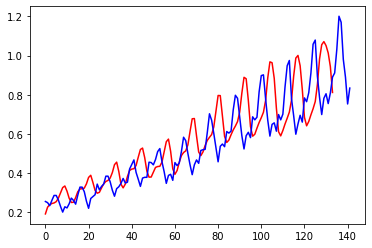

In [119]:
# Testing on the whole series (70% trained + 30% untrained):
net = net.eval() 
data_X2 = data_X.reshape(-1, 1, window_size)
data_X3 = t.from_numpy(data_X2)
pred_test1 = net(data_X3) 
pred_test2 = pred_test1.view(-1).data.numpy() # reshaping to a simple time series
print(pred_test1.shape, pred_test2.shape, len(ts))

# Visualization:
plot(pred_test2, 'r', label='prediction')
plot(ts[2:], 'b', label='real');

**討論**：<br>
根據上方的討論做了其他測試，將time window拉長之後似乎有些微的改善，尤其是=5時的效果比=10來的更好，所以說寬度還是有個極限存在，要使用LSTM模型的話窗戶寬度得適中才行。